In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import vr2p
from skimage.exposure import rescale_intensity
from matplotlib import pyplot as plt
import gcsfs, pickle
from skimage.exposure import rescale_intensity
from multiday_suite2p.utils import deform_masks,  create_mask_img
from tqdm.notebook import tqdm
import seaborn as sns
import skimage
from matplotlib.colors import ListedColormap

# Main Parameters

In [2]:
animal = 'A7'
pix_size = [1.333,2] #xy
img_type = 'mean_img'
crop_size_mm = 0.085
contours_rescale_factor = 3

# Load data

* trans_masks: (transformed mask so that they are all in 'registered' space)
* matched_cells: result of clustering (size: number of clustered cells that passed the algorithm)
                Each index contains list of clustered masks that make up that cell.)

In [ ]:
# load data.
data = vr2p.ExperimentData(f'/.../Set A-E/Tyche-{animal}/')


fs = gcsfs.GCSFileSystem(project='sprustonlab-meso')
# registration data.
with fs.open(f'/.../registration/register-Tyche-{animal}.pkl', 'rb') as handle:
    deforms, trans_images,trans_masks, trans_label_im = pickle.load(handle)
# cluster matching data.
with fs.open(f'/.../registration/match-Tyche-{animal}.pkl', 'rb') as handle:
    matched_cells, matched_im, template_masks, template_im = pickle.load(handle)

# Helper Functions

In [4]:
def show_contours_registered_masks_FOV(session, disp_range, crop_origin_mm,random_seed = 0):
    if disp_range==None:
        show_fov = False
    #plot
    fig = plt.figure(figsize=(2.5,2.5),dpi=300)
    ax = fig.add_subplot(1, 1, 1)
    #get image.
    img = data.images.registered[session]['mean_img']
    if show_fov:
        img = rescale_intensity(img,in_range=tuple(disp_range),out_range=(0,255)).astype(np.uint8)
    else:
        img = np.zeros(img.shape)
    extent=[0,(img.shape[1]*pix_size[0])/1000, 0,(img.shape[0]*pix_size[1])/1000]

    # get cell masks
    masks = trans_masks[session]
    cells_img = create_mask_img(masks, img.shape,contours=True,contour_upsampling=contours_rescale_factor)

    # create random colormap.
    num_cells = cells_img.max()
    np.random.seed(0)
    # fixed number of colors.
    rand_cmap = np.array(sns.color_palette("husl",128))
    rand_cmap = rand_cmap[np.random.choice(rand_cmap.shape[0], num_cells),:]

    # create roi image.
    img=skimage.transform.rescale(img, contours_rescale_factor,order=0)
    mask_rgb = skimage.color.label2rgb(cells_img,img, colors=rand_cmap,alpha=1,bg_color=None) # something labeled as '1' will look at the first (zero index] color in the list. create mask sets first mask as 0 in the image (so effectively skipped)

    ax.imshow(mask_rgb, origin='lower',extent=extent, interpolation='none')

    # format.
    crop_ax(ax, crop_size_mm, crop_origin_mm)
def show_registered_masks(session, crop_origin_mm,random_seed=0): 
    #plot
    fig = plt.figure(figsize=(2.5,2.5),dpi=300)
    ax = fig.add_subplot(1, 1, 1)
    #get image.
    img = data.images.registered[session]['mean_img']
    img = np.zeros(img.shape)
    extent=[0,(img.shape[1]*pix_size[0])/1000, 0,(img.shape[0]*pix_size[1])/1000]

    # get cell masks
    masks = trans_masks[session]
    cells_img = create_mask_img(masks, img.shape)

    # create random colormap.
    num_cells = cells_img.max()
    np.random.seed(random_seed)
    # fixed number of colors.
    rand_cmap = np.array(sns.color_palette("husl",128))
    rand_cmap = rand_cmap[np.random.choice(rand_cmap.shape[0], num_cells),:]

    # create roi image.
    mask_rgb = skimage.color.label2rgb(cells_img,img, colors=rand_cmap,alpha=1,bg_color=None) # something labeled as '1' will look at the first (zero index] color in the list. create mask sets first mask as 0 in the image (so effectively skipped)

    ax.imshow(mask_rgb, origin='lower',extent=extent, interpolation='none')

    # format.
    crop_ax(ax, crop_size_mm, crop_origin_mm)
    
def show_clustered_masks(session, crop_origin_mm,random_seed=0): 
    #plot
    fig = plt.figure(figsize=(2.5,2.5),dpi=300)
    ax = fig.add_subplot(1, 1, 1)
    #get image.
    img = data.images.registered[session]['mean_img']
    img = np.zeros(img.shape)
    extent=[0,(img.shape[1]*pix_size[0])/1000, 0,(img.shape[0]*pix_size[1])/1000]
    # get relevant masks.
    masks = [roi for cell in matched_cells for roi in cell if roi['session']==session]
    # create mask image.
    cells_img = create_mask_img(masks, img.shape,field='id')
    

    # create random colormap.
    num_cells = len(matched_cells)
    np.random.seed(random_seed)
    # fixed number of colors.
    rand_cmap = np.array(sns.color_palette("hls",124))
    rand_cmap = rand_cmap[np.random.choice(rand_cmap.shape[0], num_cells),:]
    rand_cmap[0,:] = [0,0,0]

    ax.imshow(cells_img, origin='lower',extent=extent, interpolation='none',cmap=ListedColormap(rand_cmap),vmin=0,vmax=num_cells)
    # format.
    crop_ax(ax, crop_size_mm, crop_origin_mm)       

def show_template_masks(session, crop_origin_mm,random_seed=0):
    #plot
    fig = plt.figure(figsize=(2.5,2.5),dpi=300)
    ax = fig.add_subplot(1, 1, 1)    
    #get image.
    img = data.images.registered[session]['mean_img']
    img = np.zeros(img.shape)
    extent=[0,(img.shape[1]*pix_size[0])/1000, 0,(img.shape[0]*pix_size[1])/1000]
    # create mask image.
    cells_img = create_mask_img(template_masks, img.shape,field='id')
    
    # create random colormap.
    num_cells = len(matched_cells)
    np.random.seed(random_seed)
    # fixed number of colors.
    rand_cmap = np.array(sns.color_palette("hls",124))
    rand_cmap = rand_cmap[np.random.choice(rand_cmap.shape[0], num_cells),:]
    rand_cmap[0,:] = [0,0,0]

    ax.imshow(cells_img, origin='lower',extent=extent, interpolation='none',cmap=ListedColormap(rand_cmap),vmin=0,vmax=num_cells)
    # format.
    crop_ax(ax, crop_size_mm, crop_origin_mm)             
    
def crop_ax(ax, crop_size_mm, crop_origin_mm):
    crop_mm = [[crop_origin_mm[0],crop_origin_mm[0] + crop_size_mm],
              [crop_origin_mm[1],crop_origin_mm[1] + crop_size_mm]] 
    ax.axis('off')
    ax.set_xlim(crop_mm[0])
    ax.set_ylim(crop_mm[1])    

# show cropped region

* Show images in registered space

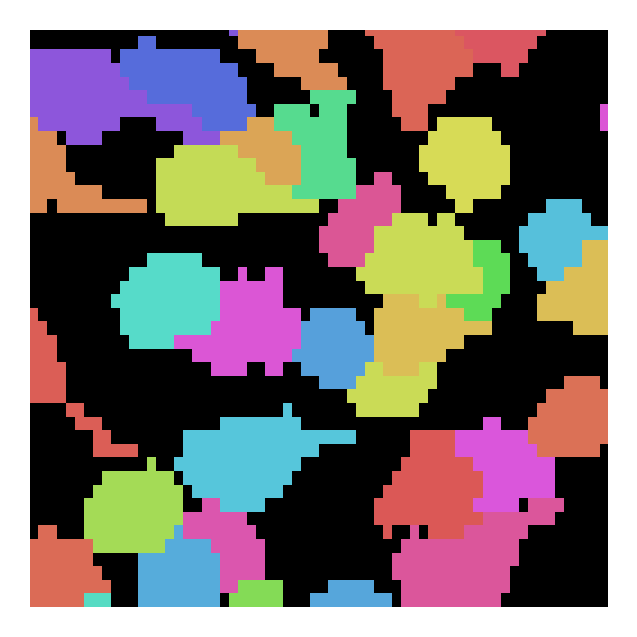

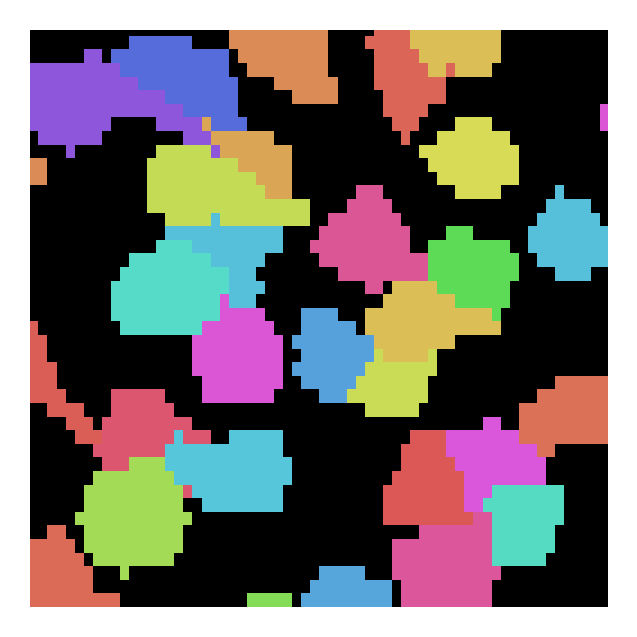

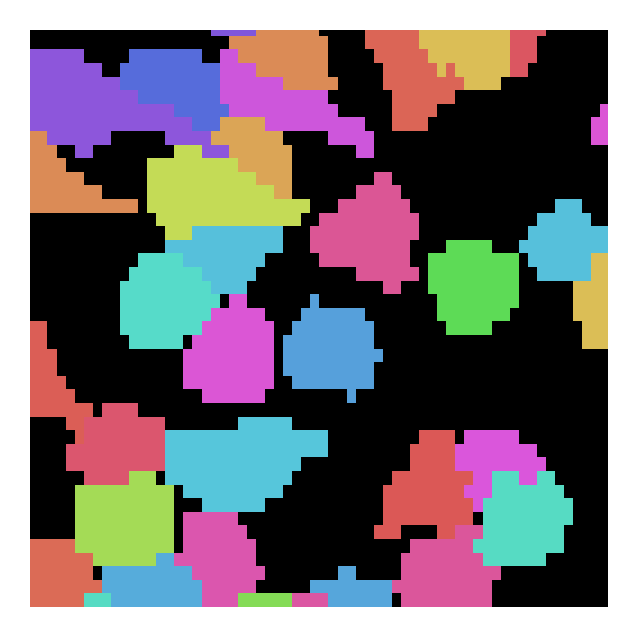

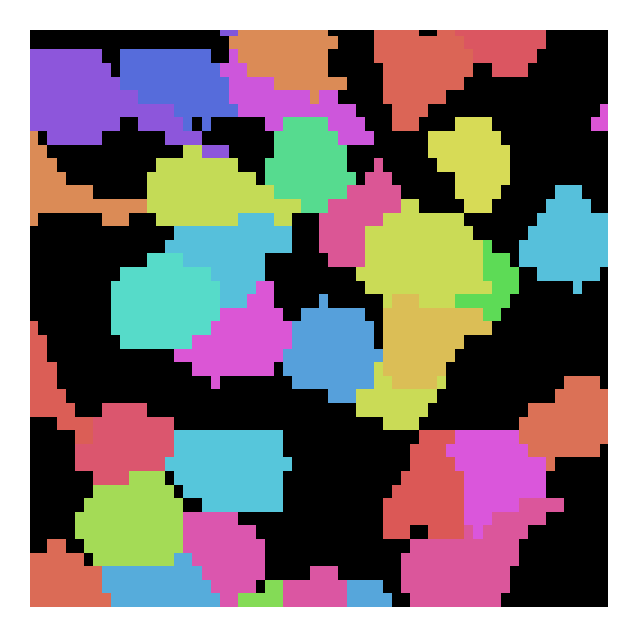

In [7]:
show_clustered_masks(session=0, crop_origin_mm = [0.4, 0.6],random_seed=0)
show_clustered_masks(session=1, crop_origin_mm = [0.4, 0.6],random_seed=0)
show_clustered_masks(session=4, crop_origin_mm = [0.4, 0.6],random_seed=0)
show_clustered_masks(session=8, crop_origin_mm = [0.4, 0.6],random_seed=0)

# SHow template mask

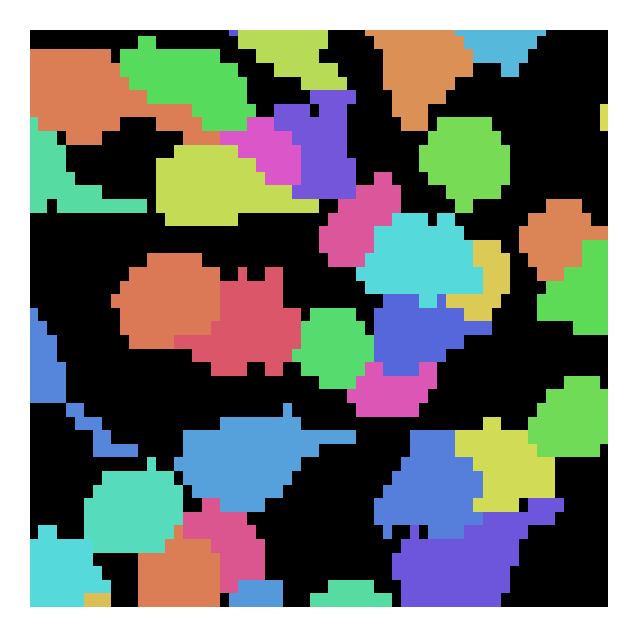

In [44]:
show_template_masks(session=0, crop_origin_mm = [0.4, 0.6],random_seed=0)